## TP de traitement d'image

In [60]:
from sklearn.decomposition import PCA
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.measure import regionprops
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

### 1. Génération d’une base d’images

La base de donné est généré avec Matlab à l'aide du fichier genere_base.m. Dans la suite du TP les nouvvelles images sont aussi générées avec Matlab.

### 2. Visualisation d'une base d'image

Visualisation de la base de donnée initiale

<img src='Formes de référence.png'>

Lancer le fichier visu_base.py pour afficher la totalité de la base de données

In [61]:
def visu_images(images, per_time):
    plt.title('Visialisation de continue des images')
    plot_img = plt.imshow(cv2.imread(images[0]))
    for i in range(len(images)):
        plot_img.set_data(cv2.imread(images[i]))
        
        plt.pause(per_time)

### 3. Obtention d'une image binaire et Extraction du contour de la forme

L’histogramme est la représentation de la distribution des pixels de l'image selon l'intensité.

Soit une image $f$ de dimension $N$ x $M$, $f(i,j)$ étant la valeur d'intensité d'un pixel de la ligne $i$ et de la colonne $j$.
<br>Alors l'image binaire est obtenu comme suite :


$$
g(i,j) = 
\begin{cases}
&255{\text{ si }}f(i,j)\geqslant s\\&0{\text{ sinon }}
\end{cases}
$$


Calcul des coefficients descriptifs de Fourier et la fonction inverse.
<br>On représente le contours par une suite ordonnée de $N$ points $(x_m,y_m)$. On construit ensuite une série de nombre complexe $z_m = x_m+iy_m$. Les descripteurs de Fourier sont: $$ a_k = \frac{1}{N} \sum_{m=0}^{N-1}(z_m-\bar{z})exp(-\frac{2\pi jkm}{N})$$ avec $\bar{z}$ la moyenne des nombres complexes.
<br>$|a_k|$ est invariant par translation.

In [62]:
def dfdir(z,cmax):
	N=z.shape[0]
	TC=np.fft.fft(z-np.mean(z))/N
	coeff=np.zeros(2*cmax+1,dtype=complex)
	coeff[cmax:2*cmax+1]=TC[0:cmax+1]/np.abs(TC[N-1])
	coeff[0:cmax]=TC[N-cmax:N]/np.abs(TC[N-1])
	return coeff

def dfinv(coeff,N):
	cmax=int((coeff.shape[0]-1)/2)
	TC=np.zeros(N,dtype=complex)
	TC[0:cmax+1]=coeff[cmax:2*cmax+1]
	TC[N-cmax:N]=coeff[0:cmax]
	z=N*np.fft.ifft(TC)
	return z


Extraction du contour de la forme

In [63]:
def find_contours(file):
    img_gray = cv2.imread(file, 0)

    _, img_bin = cv2.threshold(
        img_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(
        img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    return contours

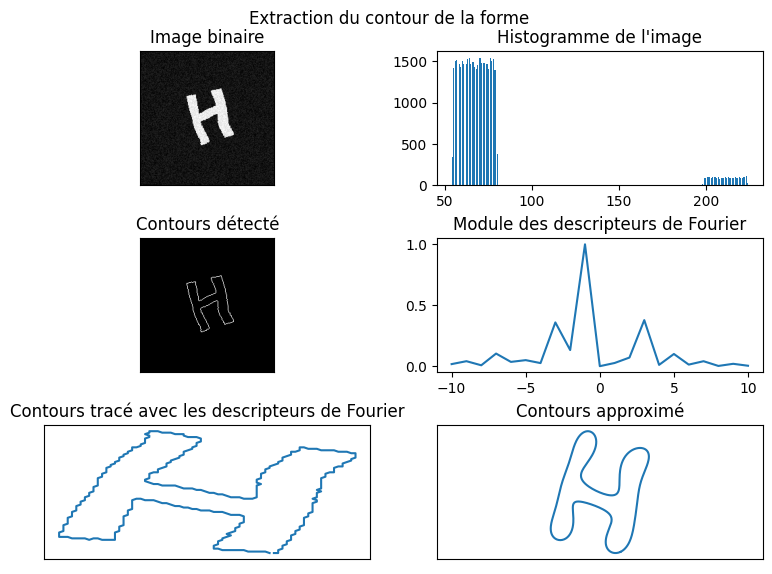

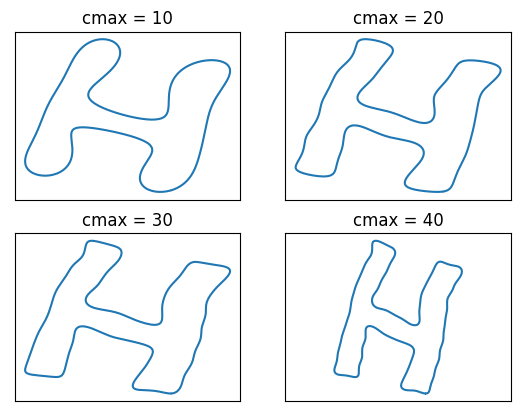

In [64]:
def contours_fourier(file):

    img_gray = cv2.imread(file, 0)

    fig, axes = plt.subplots(3, 2)
    fig.suptitle('Extraction du contour de la forme')
    fig.set_size_inches(8, 6)
    fig.tight_layout(h_pad=1.7)
    axes = axes.flatten()
    axes[0].imshow(img_gray, cmap='gray')
    axes[0].set_title('Image binaire')
    for i in [0, 2, 4, 5]:
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        
    contours  =find_contours(file)
    img_cont = np.zeros(img_gray.shape, dtype=np.uint8)

    axes[1].hist(img_gray.flatten(), bins=256)
    axes[1].set_title("Histogramme de l'image")

    cv2.drawContours(img_cont, [contours[0]], 0, 255, 1)
    axes[2].imshow(img_cont, cmap='gray')
    axes[2].set_title('Contours détecté')
    cmax=10
    cnt = np.squeeze(contours[0], axis=1)
    z = cnt[:, 0]+1j*cnt[:, 1]
    coeff = dfdir(z, cmax)
    axes[3].plot(np.arange(-cmax, cmax+1, dtype=int), np.abs(coeff))
    axes[3].set_title('Module des descripteurs de Fourier')

    N = 500
    z_f = dfinv(coeff, N)

    axes[4].plot(np.real(z), np.imag(z)), plt.axis(
        'equal'), plt.gca().invert_yaxis()
    axes[4].set_title('Contours tracé avec les descripteurs de Fourier')
    axes[5].plot(np.real(z_f), np.imag(z_f)), plt.axis(
        'equal'), plt.gca().invert_yaxis()
    axes[5].set_title('Contours approximé')
    plt.show()
    
    new_fig, new_axes = plt.subplots(2, 2)
    new_axes = new_axes.flatten()
    for i in range(4):
        new_axes[i].set_xticks([])
        new_axes[i].set_yticks([])

    

    
    for i in range(1,5):
        coeff = dfdir(z, i*10)

        N = 500
        z_f = dfinv(coeff, N)
        new_axes[i-1].plot(np.real(z_f), np.imag(z_f)), plt.axis(
        'equal'), plt.gca().invert_yaxis()
        new_axes[i-1].set_title(f'cmax = {i*10}')
    plt.show()
contours_fourier('appr\mesure001.png')

### 4. Autres paramètres géométriques : $regionprops$

In [65]:

def params_geo(file,plot_figure=True):

    img = cv2.imread(file, 0)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    regions = regionprops(img)
    r0 = regions[0]

    params = []

    for (y0,x0) in r0.coords:
        params.append(np.array([x0,y0]))
        if plot_figure:
            plt.plot(x0, y0, '.b', markersize=10)
        

    if plot_figure:
        plt.imshow(img, cmap='gray')
        plt.show()
    return r0.moments_hu

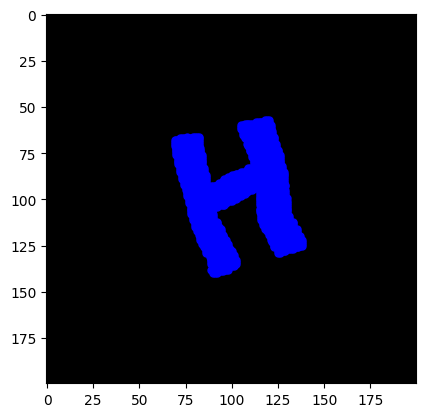

Les Moments HU sont  :
[ 3.08471413e-01  6.47442672e-04  1.66481656e-04  4.06390043e-05
 -2.72871909e-09 -1.80976434e-07  1.93073951e-09]


In [66]:
params_img = params_geo('appr/mesure001.png',True)
print("Les Moments HU sont  :")
print(params_img)

Les moments de l'image sont une moyenne pondérée des intensités des pixels de l'image. Prenons un exemple simple pour comprendre la déclaration précédente.

Pour simplifier, considérons une image binaire à un seul canal $I$. L'intensité des pixels à l'emplacement $(x,y)$ est donnée par $I(x,y)$. Remarque pour une image binaire $I(x,y)$ peut prendre la valeur $0$ ou $1$.

$$M_{ij} = \underset{x}\sum{\underset{y}\sum{}}x^i y^i I(x,y)$$

Ces moments sont souvent appelés moments bruts pour les distinguer des moments centraux.

Le centroïde d'un blob binaire est simplement son centre de masse. Le centre de gravité $(\bar{x},\bar{y})$ est calculé à l'aide de la formule suivante.

$$\bar{x} = \frac{M_{10}}{M_{00}}$$

$$\bar{y} = \frac{M_{01}}{M_{00}}$$


Les moments centraux sont très similaires aux moments d'image brute, sauf que nous soustrayons le centroïde de x et y dans la formule des moments.

$$\mu_{ij} = \underset{x}\sum{\underset{y}\sum{}}(x-\bar{x})^i (y-\bar{y})^i I(x,y)$$
Les moments centraux sont invariants par translation.

Nous introduisons les moments centraux normalisés, comme indiqué ci-dessous.

$$\eta_{ij} = \frac{\mu_{ij}}{\mu_{00}^{(i+j)/2+1}}$$




Les moments Hu (ou les invariants de moment Hu) sont un ensemble de 7 nombres calculés à l'aide de moments centraux invariants aux transformations d'image. Les 6 premiers moments se sont invariants à la translation, à l'échelle, à la rotation et à la réflexion. Alors que le signe du 7e moment change pour la réflexion de l'image.

<!-- $h_0 = \mu_{20} + \mu_{02}$

$h_1 = (\mu_{20}-\mu_{02})^2 + 4\mu_{11}^2$

$h_2 = (\mu_{30}-3\mu_{12})^2 + (3\mu_{21}-\mu_{03})^2$

$h_3 = (\mu_{30}+\mu_{12})^2 + (\mu_{21}+\mu_{03})^2$

$h_{4}=(\eta _{{30}}-3\eta _{{12}})(\eta _{{30}}+\eta _{{12}})[(\eta _{{30}}+\eta _{{12}})^{2}-3(\eta _{{21}}+\eta _{{03}})^{2}]+(3\eta _{{21}}-\eta _{{03}})(\eta _{{21}}+\eta _{{03}})[3(\eta _{{30}}+\eta _{{12}})^{2}-(\eta _{{21}}+\eta _{{03}})^{2}]$

$h_{5}=(\eta _{{20}}-\eta _{{02}})[(\eta _{{30}}+\eta _{{12}})^{2}-(\eta _{{21}}+\eta _{{03}})^{2}]+4\eta _{{11}}(\eta _{{30}}+\eta _{{12}})(\eta _{{21}}+\eta _{{03}})$

$h_{6}=(3\eta _{{21}}-\eta _{{03}})(\eta _{{30}}+\eta _{{12}})[(\eta _{{30}}+\eta _{{12}})^{2}-3(\eta _{{21}}+\eta _{{03}})^{2}]-(\eta _{{30}}-3\eta _{{12}})(\eta _{{21}}+\eta _{{03}})[3(\eta _{{30}}+\eta _{{12}})^{2}-(\eta _{{21}}+\eta _{{03}})^{2}]$ -->

### 5. Analyse en composante principale

In [67]:
def pca(file):
    cnt = find_contours(file)
    cnt = np.squeeze(cnt[0], axis=1)

    pca = PCA()
    pca.fit(cnt)
    pca_coeff = pca.components_
    
    return pca_coeff

In [68]:
pca('appr\mesure001.png')

array([[-0.29521028, -0.95543231],
       [ 0.95543231, -0.29521028]])

### 6. Méthodes des K-Moyennes

On se propose de stocker ici deux listes de paramètres : dans data_moments_hu nous stockons les 7 paramètres de moments de chaque image calculés grâce à la méthode de $regionprops$ et dans data_pca nous calculerons les modules des descripteurs de Fourier après avoir appliquer la l'analyse en composante principale aux contours. Enfin nous stockons les références de chaque image dans la liste label afin de voir si nos résultats sont bonnes.

In [69]:
data_moments_hu, data_pca = [], []
labels = []
images = ["appr/"+name for name in os.listdir('appr') if name.split('.')[-1] == 'png']
images = np.array(images)
txt_files = ["appr/"+name for name in os.listdir('appr') if name.split('.')[-1] == 'txt']



for i in range(len(images)):
    
    with open(txt_files[i]) as f:
        labels.append(int(f.readline())-1)
    
    pca_coeff = pca(images[i])
    z = pca_coeff[:, 0]+1j*pca_coeff[:, 1]
    pca_coeff = dfdir(z, z.shape[0]-1)
    data_pca.append(np.abs(pca_coeff))
    
    params_moments = params_geo(images[i],False)
    data_moments_hu.append(params_moments)

labels = np.array(labels)
    

La méthode des K-Moyennes recherche des clusters qui  regroupe les données en essayant de séparer les échantillons en k groupes de variance égale (k clusters disjoints), en minimisant un critère connu sous le nom d'inertie ou somme des carrés intra-cluster. L'inertie est : 
$$ \sum_{i=0}^{n} \min_{\mu_j \in C}(\lVert x_i-\mu_j \rVert)$$
<br>
L'inertie n'est pas une métrique normalisée : nous savons simplement que les valeurs inférieures sont meilleures et que zéro est optimal. Mais dans les espaces de très grande dimension, les distances euclidiennes ont tendance à gonfler. L'exécution d'un algorithme de réduction de dimensionnalité tel que l'analyse en composantes principales (ACP) avant le clustering k-means peut atténuer ce problème et accélérer les calculs.

Nous utiliserons la méthode Elbow qui permet d'avoir une idée sur le nombre de de clusters qu'il y a dans notre base de donnée. On calcule l'inertie obtenue après le cluster pour chaque nombre de cluster (ici entre 1 et 10). Il s'agit ici de la somme des carrés intra-cluster (WCSS : Within-Cluster Sum of Square), c'est-à-dire la somme de la distance carrée entre les points d'un cluster et le centroïde du cluster.

In [70]:
def calculate_wcss(data,data_type):
    wcss = []

    for i in range (1,10):
        kmeans= KMeans(i)
        kmeans.fit(data)
        wcss_iter = kmeans.inertia_
        wcss.append(wcss_iter)

    number_clusters = range(1,10)
    plt.plot(number_clusters, wcss)
    plt.title(f'Méthode Elbow pour {data_type}')
    plt.xlabel('Number of clusters')
    plt.ylabel('Within-cluster Sum of Squares')
    plt.show()

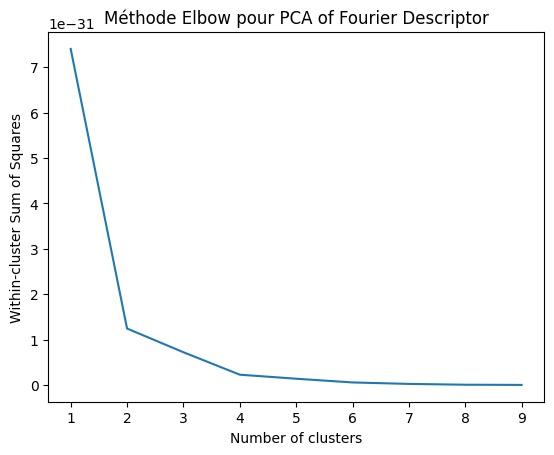

In [71]:
calculate_wcss(data=data_pca,data_type='PCA of Fourier Descriptor')

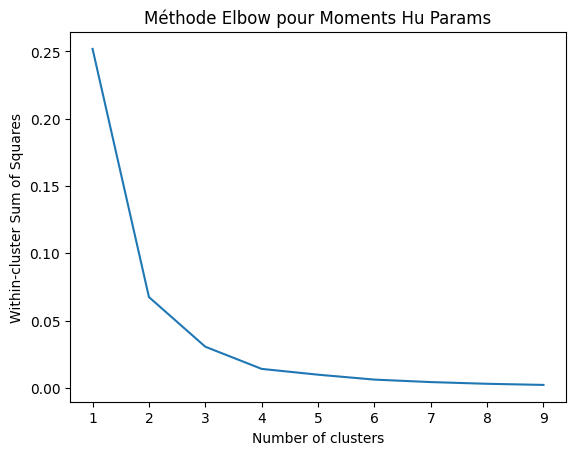

In [72]:
calculate_wcss(data=data_moments_hu,data_type='Moments Hu Params')

In [73]:
kmeans_pca = KMeans(n_clusters=6,random_state=42)
kmeans_pca.fit(data_pca)


KMeans(n_clusters=6, random_state=42)

In [74]:
# visu_images(images[np.argwhere(kmeans_pca.fit_predict(data_pca)==0)].flatten(),0.4)
# plt.close()

In [75]:
kmeans = KMeans(n_clusters=6,random_state=42)
kmeans.fit(data_moments_hu)

KMeans(n_clusters=6, random_state=42)

In [76]:
kmeans.labels_

array([3, 1, 2, 4, 4, 5, 2, 0, 3, 3, 2, 5, 5, 0, 2, 2, 3, 5, 2, 5, 1, 2,
       1, 4, 4, 3, 0, 0, 5, 5, 4, 5, 5, 4, 1, 4, 3, 2, 1, 1, 5, 1, 1, 1,
       3, 4, 1, 3, 4, 3, 1, 0, 2, 0, 0, 4, 2, 4, 3, 4, 1, 2, 2, 2, 2, 3,
       5, 1, 1, 3, 5, 2, 0, 5, 3, 5, 3, 3, 2, 3, 5, 2, 1, 4, 3, 1, 3, 3,
       3, 2, 1, 5, 4, 4, 2, 1, 5, 0, 5, 2])

In [77]:
kmeans.cluster_centers_

array([[ 1.86579470e-01,  7.16115893e-03,  1.23696114e-05,
         1.05482189e-06,  1.14692555e-11,  5.42807811e-08,
         1.15605040e-12],
       [ 2.72386094e-01,  1.28029934e-03,  1.94345995e-02,
         1.86272171e-04,  3.91513543e-08,  4.96800364e-06,
        -2.87258483e-07],
       [ 2.42517240e-01,  3.33113251e-02,  6.55356436e-05,
         1.20235283e-05,  2.61898624e-10,  1.13915301e-06,
        -1.92341037e-11],
       [ 3.01888519e-01,  4.87409368e-04,  2.26906141e-04,
         6.37099207e-05, -3.01095873e-09,  3.43964628e-07,
         1.20813339e-08],
       [ 1.59838432e-01,  8.72652001e-05,  2.08008120e-05,
         1.56551567e-08, -2.16733167e-15, -2.91969534e-11,
         1.30187015e-14],
       [ 2.63030626e-01,  4.87827804e-04,  1.14086094e-03,
         9.59876282e-05,  5.93763840e-09,  7.12346058e-07,
        -7.53127975e-10]])

In [78]:
# %matplotlib
# visu_images(images[np.argwhere(kmeans.fit_predict(data_moments_hu)==0)].flatten(),0.4)
# plt.close()
f"cluster des rectangles : {len(images[np.argwhere(kmeans.fit_predict(data_moments_hu)==0)].flatten())}"

'cluster des rectangles : 9'

In [79]:
# visu_images(images[np.argwhere(kmeans.fit_predict(data_moments_hu)==1)].flatten(),0.4)
# plt.close()
f"cluster des Y : {len(images[np.argwhere(kmeans.fit_predict(data_moments_hu)==1)].flatten())}"

'cluster des Y : 18'

In [80]:
# visu_images(images[np.argwhere(kmeans.fit_predict(data_moments_hu)==2)].flatten(),0.4)
# plt.close()
f"cluster des ellipses : {len(images[np.argwhere(kmeans.fit_predict(data_moments_hu)==2)].flatten())}"

'cluster des ellipses : 20'

In [81]:
# visu_images(images[np.argwhere(kmeans.fit_predict(data_moments_hu)==3)].flatten(),0.4)
# plt.close()
f"cluster des H : {len(images[np.argwhere(kmeans.fit_predict(data_moments_hu)==3)].flatten())}"

'cluster des H : 20'

In [82]:
# visu_images(images[np.argwhere(kmeans.fit_predict(data_moments_hu)==4)].flatten(),0.4)
# plt.close()
f"cluster des cercles : {len(images[np.argwhere(kmeans.fit_predict(data_moments_hu)==4)].flatten())}"

'cluster des cercles : 15'

In [83]:
# visu_images(images[np.argwhere(kmeans.fit_predict(data_moments_hu)==5)].flatten(),0.4)
# plt.close()
f"cluster des étoiles : {len(images[np.argwhere(kmeans.fit_predict(data_moments_hu)==5)].flatten())}"

'cluster des étoiles : 18'

### 7. Méthode des K plus proches voisins

Nous passons à l'utilisation de la méthode des K plus proches voisins dont la classification est basée sur les voisins qui stocke simplement des instances des données d'apprentissage. La classification est calculée à partir d'un vote à la majorité simple des plus proches voisins de chaque point : un point de requête se voit attribuer la classe de données qui a le plus de représentants parmi les plus proches voisins du point.

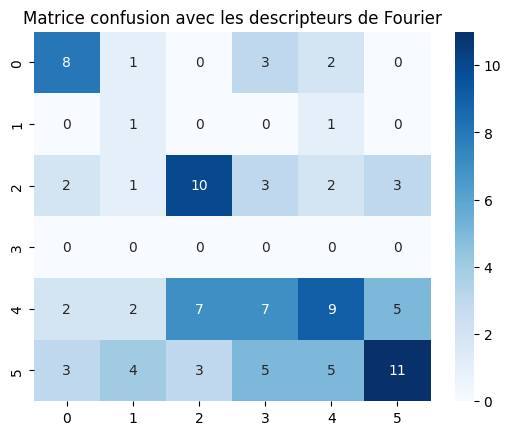

In [84]:
classifier_pca = KNeighborsClassifier(n_neighbors=1)
classifier_pca.fit(data_pca,labels)
cm = confusion_matrix(classifier_pca.predict(data_pca),labels)
sns.heatmap(cm,annot=True,cmap='Blues')
plt.title("Matrice confusion avec les descripteurs de Fourier")
plt.show()

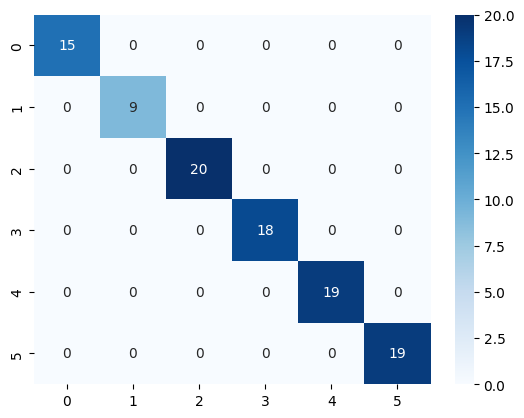

In [85]:

classifier_moments = KNeighborsClassifier(n_neighbors=1)
classifier_moments.fit(data_moments_hu,labels)
cm = confusion_matrix(classifier_moments.predict(data_moments_hu),labels)
sns.heatmap(cm,annot=True,cmap='Blues')
plt.show()

### 8. Evaluation des performances

Nous créons le fichier de test avec les paramètres suivants : $N=100$, $\sigma=0.07$, $\Delta X = \Delta Y=30$ et $NX=NY=15$.

In [86]:
test_data =  []
test_labels = []
test_images = ["test/"+name for name in os.listdir('test') if name.split('.')[-1] == 'png']
test_images = np.array(test_images)
txt_files = ["test/"+name for name in os.listdir('test') if name.split('.')[-1] == 'txt']

In [87]:
# visu_images(test_images,0.05)
# plt.close()

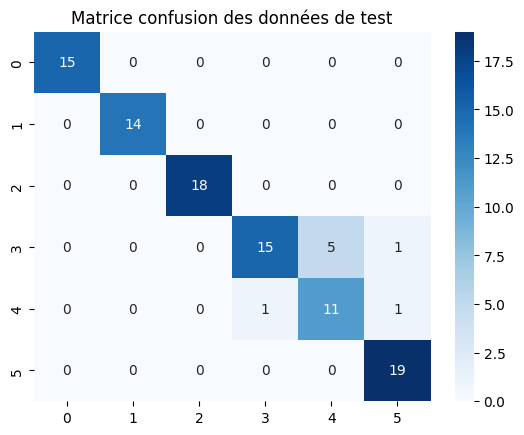

In [88]:
for i in range(len(test_images)):
    
    with open(txt_files[i]) as f:
        test_labels.append(int(f.readline())-1)
    
    params_moments = params_geo(test_images[i],False)
    test_data.append(params_moments)

test_labels = np.array(test_labels)

cm_test = confusion_matrix(classifier_moments.predict(test_data),test_labels)
sns.heatmap(cm_test,annot=True,cmap='Blues')
plt.title("Matrice confusion des données de test")
plt.show()

### 9. Généralisation à d'autres formes : les chiffres

Ici nou divisons par 255 afin que le programme écrit en Matlab puisse fonctionner. Les images sont toutes noir mais il suffit de faire une transformation en binaire pour voir les chiffres. Le dossier chiffres_0 contient des chiffres écrits à la main sur tablette à l'aide de l'application procreate et ramener à une tail de $200$ x $200$ avec OpenCV.

In [89]:
liste = ['chiffres_0/'+name for name in os.listdir('chiffres_0')]
for file in liste:
    img = cv2.imread(file)/255
    
    new_img = cv2.resize(img,(200,200))
    cv2.imwrite('chiffres/'+file.split('/')[-1],new_img)



Nous lançons le programme qui trace les contours avec une image de la base dde données d'entrainement pour avoir un aperçu des formes obtenues et également une idée de la classification.

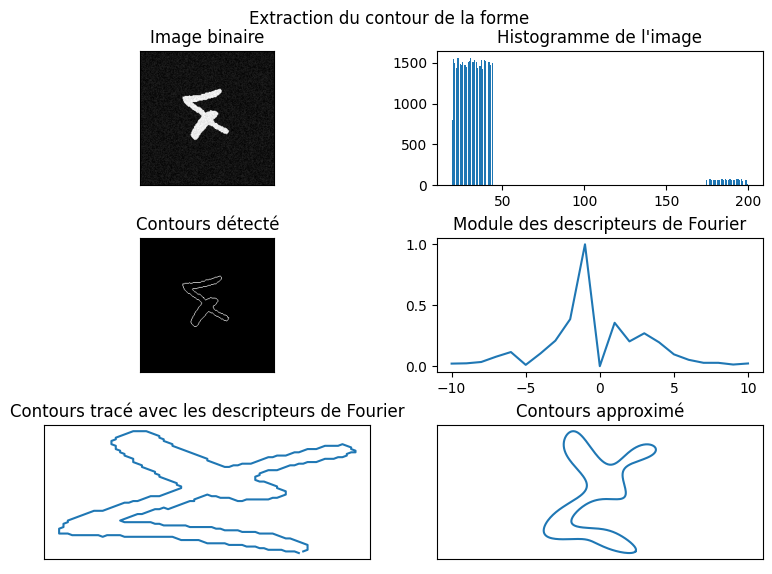

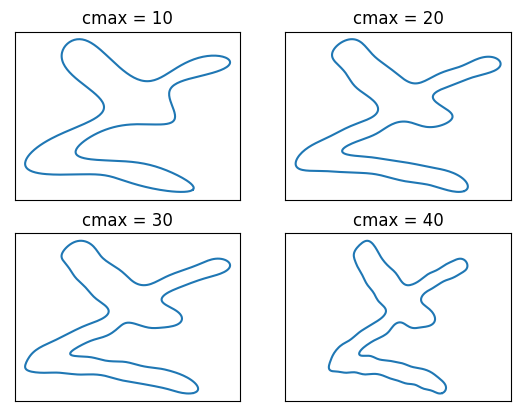

In [90]:
contours_fourier('chiffres_train\mesure011.png')

On charge les images et les labels.

In [91]:
train_data =  []
train_labels = []
train_images = ["chiffres_train/"+name for name in os.listdir('chiffres_train') if name.split('.')[-1] == 'png']
train_images = np.array(train_images)
txt_files = ["chiffres_train/"+name for name in os.listdir('chiffres_train') if name.split('.')[-1] == 'txt']

for i in range(len(train_images)):
    
    with open(txt_files[i]) as f:
        train_labels.append(int(f.readline().split('.')[0].split('_')[-1]))
    
    params_moments = params_geo(train_images[i],False)
    train_data.append(params_moments)

train_labels = np.array(train_labels)

On passe à l'entrainement sur la base des 500 images.

In [92]:
classifier_chiffres = KNeighborsClassifier(n_neighbors=1)
classifier_chiffres.fit(train_data,train_labels)

KNeighborsClassifier(n_neighbors=1)

On effectue le test sur la base des 100 images et on représente la matrice de confusion.

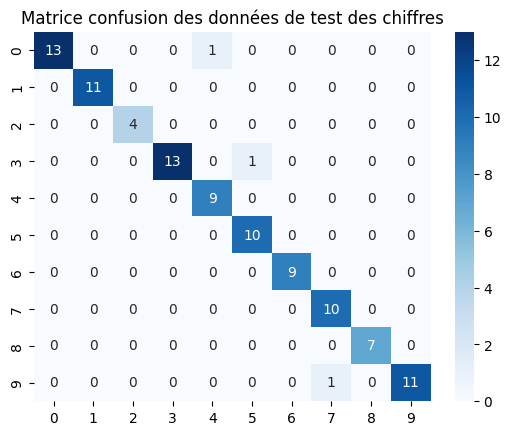

In [93]:
test_data =  []
test_labels = []
test_images = ["chiffres_test/"+name for name in os.listdir('chiffres_test') if name.split('.')[-1] == 'png']
test_images = np.array(test_images)
txt_files = ["chiffres_test/"+name for name in os.listdir('chiffres_test') if name.split('.')[-1] == 'txt']

for i in range(len(test_images)):
    
    with open(txt_files[i]) as f:
        test_labels.append(int(f.readline().split('.')[0].split('_')[-1]))
    
    params_moments = params_geo(test_images[i],False)
    test_data.append(params_moments)

test_labels = np.array(test_labels)
cm_test = confusion_matrix(classifier_chiffres.predict(test_data),test_labels)
sns.heatmap(cm_test,annot=True,cmap='Blues')
plt.title("Matrice confusion des données de test des chiffres")
plt.show()